In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
period1 = pd.read_excel("C:/Users/stlp/Downloads/day2019_1to6.xlsx")

In [3]:
period1['OPD_DATE'] = pd.to_datetime(period1['OPD_DATE'])

period1 = period1.sort_values(by='OPD_DATE')

period1.index = pd.to_datetime(period1['OPD_DATE'])

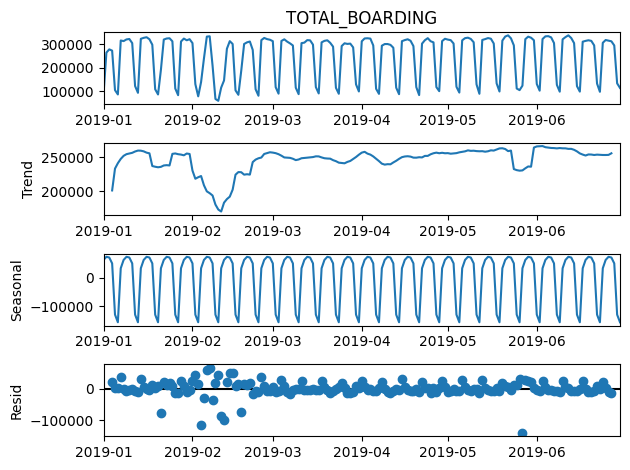

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(period1['TOTAL_BOARDING'], model="additive")
decompose_data.plot();

In [5]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
boardings = pd.Series(period1['TOTAL_BOARDING'].tolist(), period1['OPD_DATE'])
boardings.replace(0, 0.000000001, inplace=True)

smoothing_level = 0.1
ses_lat = SimpleExpSmoothing(boardings, initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=True)
#pred_lat = ses_lat.predict(start=lat_tc.index[0], end=lat_tc.index[-1])
#pred_lat_comp = pred_lat[pred_lat.index.isin(unix_min_te)]

C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [7]:
period1

,Unnamed: 0,OPD_DATE,TOTAL_BOARDING,TOTAL_ALIGHTING
OPD_DATE,,,,
2019-01-01,3,2019-01-01,86197,86121
2019-01-02,9,2019-01-02,263970,263872
2019-01-03,15,2019-01-03,277810,277629
2019-01-04,21,2019-01-04,272369,272111
2019-01-05,27,2019-01-05,104213,104198
...,...,...,...,...
2019-06-26,154,2019-06-26,314755,314654
2019-06-27,160,2019-06-27,312142,311998
2019-06-28,166,2019-06-28,294422,294311


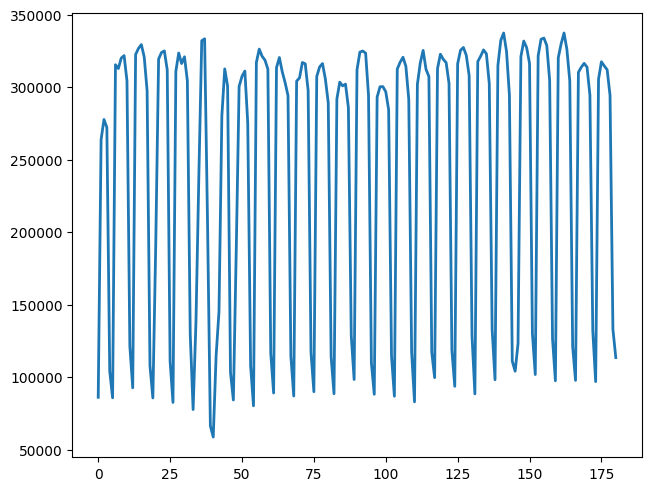

In [8]:
f, ax1 = plt.subplots(constrained_layout = True)
ax1.plot(range(len(boardings)), boardings, label='train', linewidth=2)
plt.show()

## Weekday
* Only Tuesday, Wednesday, and Thursdays

In [9]:
wkday = pd.read_csv("C:/Users/stlp/Downloads/T_daily_weekday2.csv")

In [10]:
wkday.weekday.unique()

array([3, 4, 5], dtype=int64)

In [11]:
wkday['OPD_DATE'] = pd.to_datetime(wkday['OPD_DATE'])

wkday = wkday.sort_values(by='OPD_DATE')

In [12]:
boardings = pd.Series(wkday['TOTAL_BOARDING'].tolist(), wkday['OPD_DATE'].tolist())
boardings.replace(0, 0.000000001, inplace=True)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

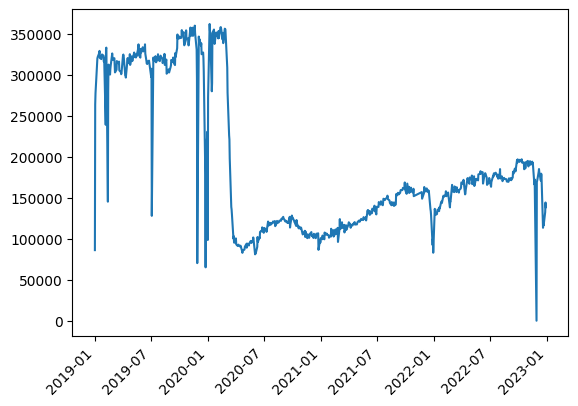

In [13]:
boardings.plot()
# Rotate x-labels
plt.xticks(rotation=45)

In [14]:
boardings.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-22',
               ...
               '2022-12-08', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', length=634, freq=None)

## Pre-COVID analysis

<Axes: >

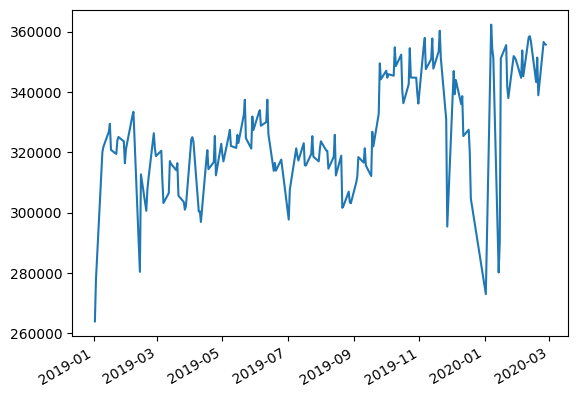

In [15]:
# Exclude post-COVID data; threshold is 2020-03-01
pre_boardings = boardings[boardings.index < '2020-03-01']

# Remove outlier days; threshold is 200,000
pre_boardings = pre_boardings[pre_boardings > 260000]

# Plot pre-COVID data
pre_boardings.plot()

In [16]:
pre_boardings.shape

(173,)

#### Split into training and testing sets (with 5-fold CV)

In [17]:
# Split into train and test sets using k-fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Create a list of train and test sets
train_test_sets = []
for train_index, test_index in tscv.split(pre_boardings):
    train_test_sets.append((pre_boardings.iloc[train_index], pre_boardings.iloc[test_index]))

In [18]:
# Check if any in test set are in train set
for train, test in train_test_sets:
    print(train.index.intersection(test.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


#### Exponential Smoothing ####

In [19]:
# For each train and test set, fit a model and predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a list of RMSEs
rmse_list_es = []
count = 0
# Loop through each train and test set
for train, test in train_test_sets:
    print(len(train))
    train = train.groupby(train.index).mean().reset_index()
    test = test.groupby(test.index).mean().reset_index()
    # Fit a model
    model = ExponentialSmoothing(train[0], trend='add', seasonal='add', seasonal_periods=10, damped_trend=True, initialization_method='estimated')
    model_fit = model.fit()
    # Predict
    yhat = model_fit.predict(start=test.index[0], end=test.index[-1])
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test[0], yhat))
    rmse_list_es.append(rmse)

    # Plot using subplots
    # f, axs = plt.subplots(5,1,figsize=(7,5))
    # axs[count].plot(train.index, train[0], label='train')
    # axs[count].plot(test.index, test[0], label='test')
    # axs[count].plot(test.index, yhat, label='prediction')
    # axs[count].legend()
    # count += 1
    # plt.show()
    

33


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


61


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


89


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


117


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


145


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [20]:
rmse_list_es

[14735.999726333765,
 16081.792887600532,
 20136.093057201175,
 33957.92003903569,
 35332.30924326381]

#### SARIMAX ####

In [21]:
# Create list of RMSEs
rmse_list_sarima = []

# Loop through each train and test set
for train, test in train_test_sets:
    print(len(train))
    train = train.groupby(train.index).mean().reset_index()
    test = test.groupby(test.index).mean().reset_index()
    # Fit a model
    model = SARIMAX(train[0], order=(3, 1, 3), seasonal_order=(1, 0, 1, 12), initialization_method='estimated')
    model_fit = model.fit(dist=False)
    # Predict
    yhat = model_fit.predict(start=test.index[0], end=test.index[-1])
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test[0], yhat))
    rmse_list_sarima.append(rmse)

33


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed ke

61


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dist. After release 0.14, this will raise.
  warnings.warn(
C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model

89


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dist. After release 0.14, this will raise.
  warnings.warn(


117


C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dist. After release 0.14, this will raise.
  warnings.warn(


145


In [22]:
rmse_list_sarima

[59657.8671691908,
 65269.50188819647,
 64451.88081247419,
 75047.87890526358,
 72297.30173528276]

In [23]:
# Run once only!
pre_boardings = pre_boardings.groupby(pre_boardings.index).mean().reset_index()

C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dist. After release 0.14, this will raise.
  warnings.warn(


<Axes: >

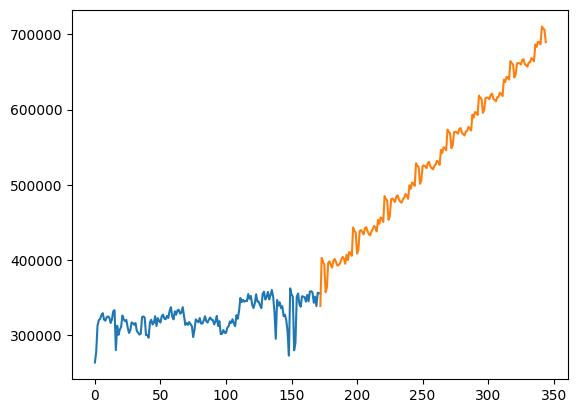

In [24]:
# Extrapolate three years using SARIMAX model
model = SARIMAX(pre_boardings[0], order=(3, 1, 1), seasonal_order=(3, 1, 1, 24), initialization_method='estimated')
model_fit = model.fit(dist=False)
yhat = model_fit.predict(start=pre_boardings.index[-1], end=pre_boardings.index[-1]*2)

# Plot predictions
pre_boardings[0].plot()
yhat.plot()

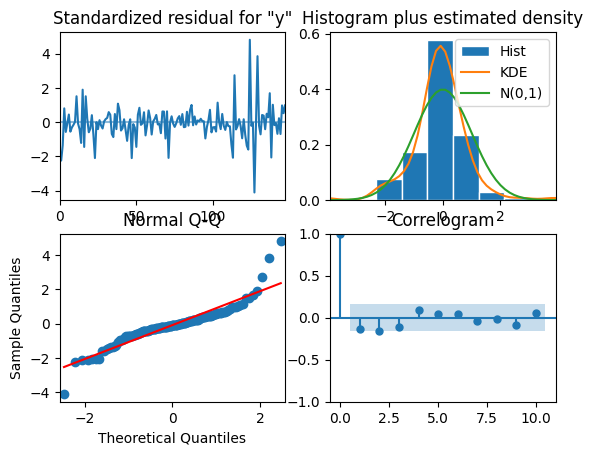

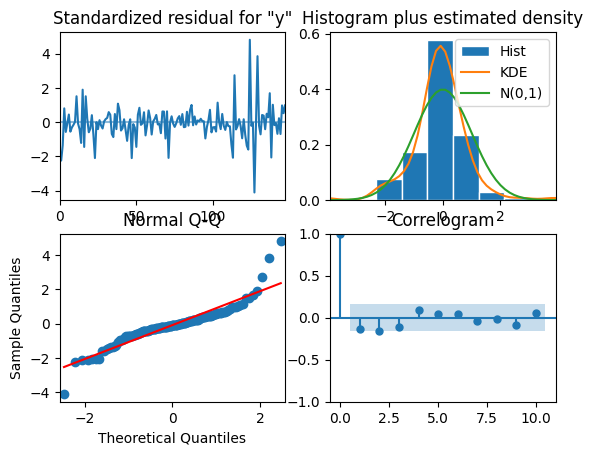

In [25]:
model_fit.plot_diagnostics()

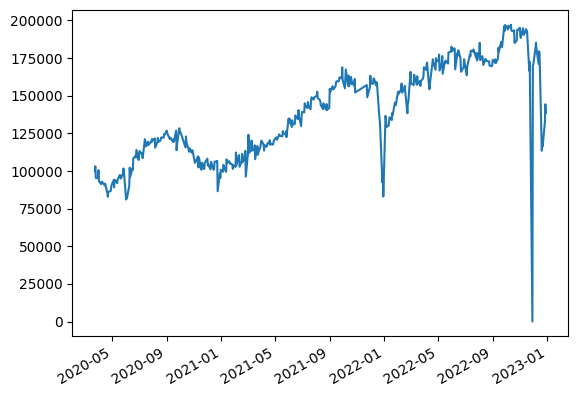

In [26]:
# Exclude pre-COVID data; threshold is 2020-03-19
post_boardings = boardings[boardings.index > '2020-03-19']

# Plot pre-COVID data
post_boardings.plot()

# Run this only once!
post_boardings = post_boardings.groupby(post_boardings.index).mean().reset_index()

# Shift index by 147 units
post_boardings.index = post_boardings.index + 173

C:\Users\stlp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


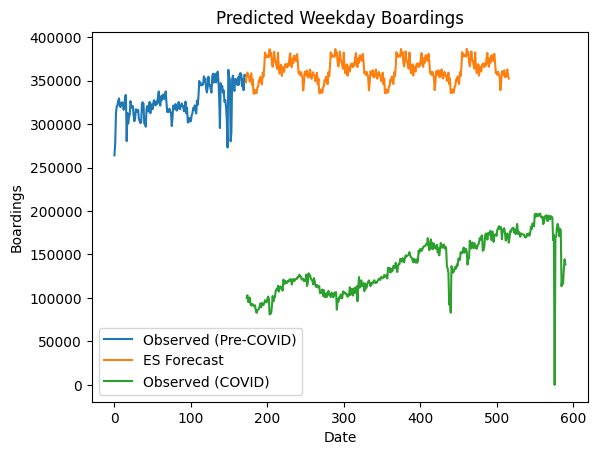

In [27]:
# Extrapolate two years using Exponential Smoothing model
model = ExponentialSmoothing(pre_boardings[0], trend='add', seasonal='add', seasonal_periods=86, damped_trend=True, initialization_method='estimated')
model_fit = model.fit()
yhat = model_fit.predict(start=pre_boardings.index[-1], end=pre_boardings.index[-1]*3)

# Plot predictions and observed data
pre_boardings[0].plot()
yhat.plot()
post_boardings[0].plot()

# Add labels
plt.xlabel('Date')
plt.ylabel('Boardings')
plt.title('Predicted Weekday Boardings')

# Add legend
plt.legend(['Observed (Pre-COVID)', 'ES Forecast', 'Observed (COVID)'])

In [28]:
model_fit.summary()

Dep. Variable:,0,No. Observations:,173
Model:,ExponentialSmoothing,SSE,37076918054.394
Optimized:,True,AIC,3500.654
Trend:,Additive,BIC,3787.603
Seasonal:,Additive,AICC,3721.970
Seasonal Periods:,86,Date:,"Wed, 08 Mar 2023"
Box-Cox:,False,Time:,15:36:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4646429,alpha,True
smoothing_trend,0.0001,beta,True


## Gaussian Process
* Try segregating at the census level
* Incorporate spatial factors (pop. density, employment, land use classification)

In [269]:
# Exclude post-COVID data; threshold is 2020-03-01
pre_boardings = boardings[boardings.index < '2020-03-01']

# Remove outlier days; threshold is 200,000
pre_boardings = pre_boardings[pre_boardings > 260000]

pre_boardings = pre_boardings.groupby(pre_boardings.index).mean().reset_index()

pre_boardings.columns = ['Date', 'Boardings']

In [281]:
import torch
import gpytorch
import math

pre_boardings['Date'] = pd.to_datetime(pre_boardings['Date'])

# Add temporal dimensions
pre_boardings['Day'] = pre_boardings['Date'].dt.day
pre_boardings['DoW'] = pre_boardings['Date'].dt.dayofweek
pre_boardings['Month'] = pre_boardings['Date'].dt.month
pre_boardings['Year'] = pre_boardings['Date'].dt.year
pre_boardings['Week'] = pre_boardings['Date'].dt.week
pre_boardings['Quarter'] = pre_boardings['Date'].dt.quarter
pre_boardings['WoM'] = pd.to_numeric(pre_boardings['Date'].dt.day/7).apply(lambda x: math.ceil(x))
# Normalized unix time
pre_boardings['Unix'] = (pre_boardings['Date'] - pd.Timestamp("2019-01-01")) // pd.Timedelta('1d')

days = pd.get_dummies(pre_boardings['DoW']).to_numpy()
days_col = pd.get_dummies(pre_boardings['DoW']).columns
days_ind = []
for i in days_col:
    days_ind.append("day_" + str(i))

pre_boardings[days_ind] = days

weeks = pd.get_dummies(pre_boardings['WoM']).to_numpy()
weeks_col = pd.get_dummies(pre_boardings['WoM']).columns
week_ind = []
for i in weeks_col:
    week_ind.append("week_" + str(i))

pre_boardings[week_ind] = weeks

months = pd.get_dummies(pre_boardings['Month']).to_numpy()
months_col = pd.get_dummies(pre_boardings['Month']).columns
month_ind = []
for i in months_col:
    month_ind.append("month_" + str(i))
pre_boardings[month_ind] = months

#years = pd.get_dummies(pre_boardings['Year']).to_numpy()    
#years_col = pd.get_dummies(pre_boardings['Year']).columns
#year_ind = []
#for i in years_col:
#    year_ind.append("year_" + str(i))
#pre_boardings[year_ind] = years

#quarters = pd.get_dummies(pre_boardings['Quarter']).to_numpy()
#quarters_col = pd.get_dummies(pre_boardings['Quarter']).columns
#quarter_ind = []
#for i in quarters_col:
#    quarter_ind.append("quarter_" + str(i))
#pre_boardings[quarter_ind] = quarters

unix_index = len(pre_boardings.columns) - pre_boardings.columns.get_loc('Unix')

# Define train and test sets for boardings
X_train = torch.tensor(np.asarray(pre_boardings.iloc[:, -unix_index:])).float()
y_train = torch.tensor(pre_boardings['Boardings'].values).float()

C:\Users\stlp\AppData\Local\Temp\ipykernel_16556\3345239116.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  pre_boardings['Week'] = pre_boardings['Date'].dt.week


In [301]:
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RQKernel, PeriodicKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import SmoothedBoxPrior

n_dims = X_train.shape[1]
print(n_dims)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RQKernel(ard_num_dims=n_dims)) * ScaleKernel(PeriodicKernel(active_dims=[0], 
                                                                     period_length_prior=SmoothedBoxPrior(math.exp(-1), math.exp(1), sigma=0.1, transform=None), 
                                                                     lengthscale_prior=SmoothedBoxPrior(math.exp(-1), math.exp(1), sigma=0.1, transform=None)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

21


In [302]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 10000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [303]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/10000 - Loss: 39660163072.000  noise: 0.693
Iter 2/10000 - Loss: 34450337792.000  noise: 0.744
Iter 3/10000 - Loss: 28677953536.000  noise: 0.798
Iter 4/10000 - Loss: 22904457216.000  noise: 0.851
Iter 5/10000 - Loss: 17147189248.000  noise: 0.905
Iter 6/10000 - Loss: 13719078912.000  noise: 0.956
Iter 7/10000 - Loss: 9565599744.000  noise: 1.004
Iter 8/10000 - Loss: 8596459520.000  noise: 1.049
Iter 9/10000 - Loss: 6651460096.000  noise: 1.091
Iter 10/10000 - Loss: 5147993088.000  noise: 1.130
Iter 11/10000 - Loss: 3973482496.000  noise: 1.166
Iter 12/10000 - Loss: 3011938816.000  noise: 1.199
Iter 13/10000 - Loss: 2259988992.000  noise: 1.230
Iter 14/10000 - Loss: 2053675904.000  noise: 1.257
Iter 15/10000 - Loss: 1751112320.000  noise: 1.283
Iter 16/10000 - Loss: 1495513472.000  noise: 1.306
Iter 17/10000 - Loss: 1290644736.000  noise: 1.328
Iter 18/10000 - Loss: 1126011776.000  noise: 1.347
Iter 19/10000 - Loss: 992804928.000  noise: 1.365
Iter 20/10000 - Loss: 879598272.000

In [304]:
# Generate a datetime object spanning from the end of our training set to the end of 2022

import datetime

# Create a date object from your input
start_date = pre_boardings['Date'].iloc[-1]

# Create an empty list to store the dates
dates = []

# Loop until you reach the end of 2021
while start_date.year < 2022:
    # Check if the date is a Tuesday, Wednesday, or Thursday
    if start_date.weekday() in [1, 2, 3]:
        # Append the date to the list
        dates.append(start_date)
    # Add one day to the date
    start_date += datetime.timedelta(days=1)

test = pd.to_datetime(dates)

In [305]:
dates = pd.DataFrame(test, columns=['Date'])

# Let's create a testing set with dates
dates['Day'] = dates['Date'].dt.day
dates['DoW'] = dates['Date'].dt.dayofweek
dates['Month'] = dates['Date'].dt.month
dates['Year'] = dates['Date'].dt.year
dates['Week'] = dates['Date'].dt.week
dates['Quarter'] = dates['Date'].dt.quarter
dates['WoM'] = pd.to_numeric(dates['Date'].dt.day/7).apply(lambda x: math.ceil(x))
# Normalized unix time
dates['Unix'] = (dates['Date'] - pd.Timestamp("2019-01-01")) // pd.Timedelta('1d')

days = pd.get_dummies(dates['DoW']).to_numpy()
days_col = pd.get_dummies(dates['DoW']).columns
days_ind = []
for i in days_col:
    days_ind.append("day_" + str(i))

dates[days_ind] = days

weeks = pd.get_dummies(dates['WoM']).to_numpy()
weeks_col = pd.get_dummies(dates['WoM']).columns
week_ind = []
for i in weeks_col:
    week_ind.append("week_" + str(i))

dates[week_ind] = weeks

months = pd.get_dummies(dates['Month']).to_numpy()
months_col = pd.get_dummies(dates['Month']).columns
month_ind = []
for i in months_col:
    month_ind.append("month_" + str(i))
dates[month_ind] = months

#years = pd.get_dummies(dates['Year']).to_numpy()
#years_col = pd.get_dummies(dates['Year']).columns
#year_ind = []
#for i in years_col:
#    year_ind.append("year_" + str(i))
#dates[year_ind] = years 

#quarters = pd.get_dummies(dates['Quarter']).to_numpy()
#quarters_col = pd.get_dummies(dates['Quarter']).columns
#quarter_ind = []
#for i in quarters_col:
#    quarter_ind.append("quarter_" + str(i))
#dates[quarter_ind] = quarters

# Define train and test sets for boardings
X_test = torch.tensor(np.asarray(dates.iloc[:, -unix_index:]))

C:\Users\stlp\AppData\Local\Temp\ipykernel_16556\2047479925.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dates['Week'] = dates['Date'].dt.week


In [306]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))

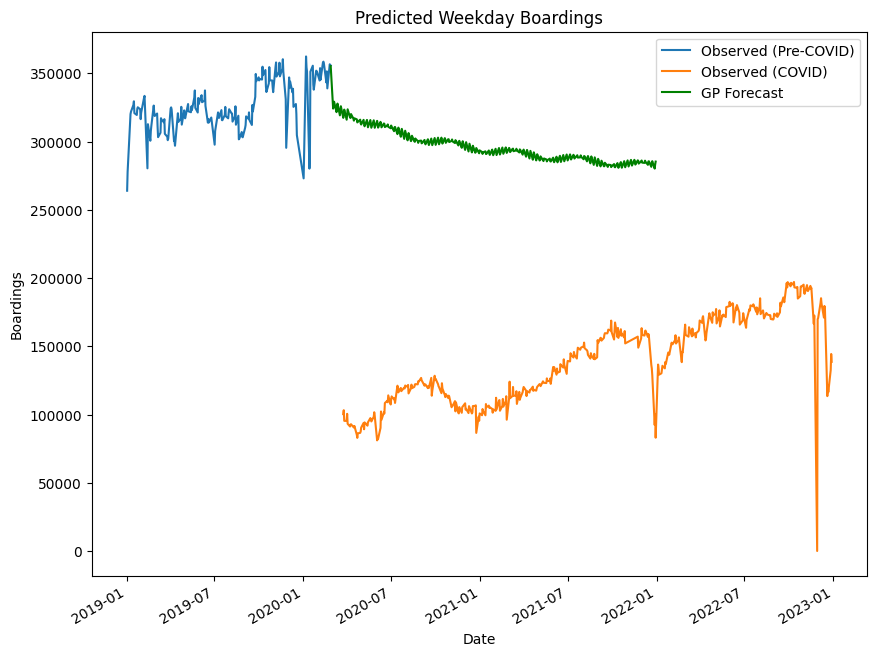

In [307]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # Plot predictions and observed data
    pre_boardings.iloc[:,0:2].plot(x='Date', y='Boardings', ax=ax)
    post_boardings.iloc[:,0:2].plot(x='index', y=0, ax=ax)

    ax.plot(test, observed_pred.mean.numpy(), 'g')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test, lower.numpy(), upper.numpy(), alpha=1.0)
    # Add labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Boardings')
    ax.set_title('Predicted Weekday Boardings')

    # Add legend
    ax.legend(['Observed (Pre-COVID)', 'Observed (COVID)', 'GP Forecast'])

In [325]:
# Drop 5th column
dates = dates.drop(dates.columns[5], axis=1)

# Put last column in the 5th index
dates.insert(4, 'Week', dates.pop(dates.columns[-1]))

In [331]:
# Rename column
dates = dates.rename(columns={dates.columns[-1]: "WoM"})

,Date,Day,DoW,Month,Week,Year,Quarter,WoM,Unix,day_1,...,week_4,week_5,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8
0,2020-02-27,27,3,2,0,2020,1,4,422,0,...,1,0,0,1,0,0,0,0,0,0
1,2020-03-03,3,1,3,0,2020,1,1,427,1,...,0,0,0,0,1,0,0,0,0,0
2,2020-03-04,4,2,3,0,2020,1,1,428,0,...,0,0,0,0,1,0,0,0,0,0
3,2020-03-05,5,3,3,0,2020,1,1,429,0,...,0,0,0,0,1,0,0,0,0,0
4,2020-03-10,10,1,3,0,2020,1,2,434,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,2021-12-22,22,2,12,0,2021,4,4,1086,0,...,1,0,0,0,0,0,0,0,0,0
285,2021-12-23,23,3,12,0,2021,4,4,1087,0,...,1,0,0,0,0,0,0,0,0,0
286,2021-12-28,28,1,12,0,2021,4,4,1092,1,...,1,0,0,0,0,0,0,0,0,0
287,2021-12-29,29,2,12,0,2021,4,5,1093,0,...,0,1,0,0,0,0,0,0,0,0


In [310]:
# Examine the model parameters
for i in model.named_parameters():
    print(i)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([4.3065], requires_grad=True))
('mean_module.raw_constant', Parameter containing:
tensor(45.1258, requires_grad=True))
('covar_module.kernels.0.raw_outputscale', Parameter containing:
tensor(18.2358, requires_grad=True))
('covar_module.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[-0.4100,  3.3874,  3.2373, -1.7474,  4.6230,  6.5109,  6.1047,  0.3672,
          2.4624,  3.5487,  3.1038, -4.3019,  0.2210,  2.0403,  2.8840,  2.4584,
          2.6685,  3.8781,  3.4619, -3.1294,  2.4969]], requires_grad=True))
('covar_module.kernels.0.base_kernel.raw_alpha', Parameter containing:
tensor([-3.3577], requires_grad=True))
('covar_module.kernels.1.raw_outputscale', Parameter containing:
tensor(18.2358, requires_grad=True))
('covar_module.kernels.1.base_kernel.raw_lengthscale', Parameter containing:
tensor([[10.0343]], requires_grad=True))
('covar_module.kernels.1.base_kernel.raw_period_length', Parameter 

<Axes: >

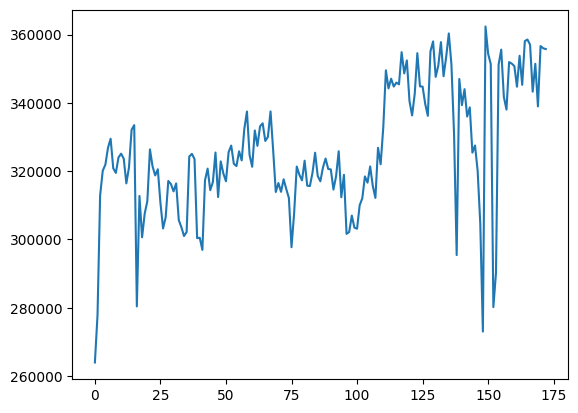

In [200]:
pre_boardings.iloc[:,1].plot()